# OSZTYN

### BASIC STATS

In [1]:
import os
import subprocess
import datetime

# prepering directories
path = os.getcwd()
# subfolders
input_dir = os.path.join(path, 'inputs')
output_dir = os.path.join(path, 'outputs')

# open folder
subprocess.Popen(f'explorer "{output_dir}"')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.dates import DateFormatter

# to supres Pandas warnings
import warnings
warnings.filterwarnings('ignore')


Bad key "text.kerning_factor" on line 4 in
C:\Users\Ukasz\Anaconda3\envs\geopandas\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
file_name = '20240116_olsztyn_details_downloaded_on16th_jan.csv'
data = pd.read_csv(os.path.join(os.getcwd(), 'outputs', file_name))

In [4]:
data.shape

(817, 34)

In [5]:
data.head(1)

,free_text,address,price,price_meter,rooms,area,more,add_link,Powierzchnia,Forma własności,...,Winda,Media,Zabezpieczenia,Wyposażenie,Informacje dodatkowe,Materiał budynku,scraping_date,address_new,Longitude,Latitude
0,"atrakcyjna kawalerka, Belweder",Mieszkanie na sprzedaż: ul. ks. Jerzego Popieł...,415000.0,10988,1 pokój,37.77,Biuro nieruchomości,/pl/oferta/atrakcyjna-kawalerka-belweder-ID4oIIB,"37,77 m²",pełna własność,...,nie,brak informacji,"teren zamknięty, domofon / wideofon",meble,piwnica,brak informacji,2024-01-16,"ks. Jerzego Popiełuszki, Osiedle Generałów, Ol...",20.478826,53.739112


#### Cleaning the 'price' column

In [6]:
# data['price'] = data['price'].str.replace(u'\xa0', u' ')
# data['price'] = data['price'].str.replace(' ', '', regex=True)
# data['price'] = data['price'].str.replace('zł', '', regex=True)
# data['price'] = data['price'].str.replace(',', '.', regex=True)
# drop nan
data = data[data['price'].notna()]
data['price'] = pd.to_numeric(data['price'])

#### Cleaning the 'price_meter' column

In [7]:
# data['price_meter'] = data['price_meter'].str.replace(u'\xa0', u' ')
# data['price_meter'] = data['price_meter'].str.replace(' ', '', regex=True)
# data['price_meter'] = data['price_meter'].str.replace('zł/m²', '', regex=True)
# data['price_meter'] = data['price_meter'].str.replace(',', '.', regex=True)
# drop nan
data = data[data['price_meter'].notna()]
data['price_meter'] = pd.to_numeric(data['price_meter'])

#### Cleaning the 'area' column

In [8]:
# data['area'] = data['area'].str.replace(u'\xa0', u' ')
# data['area'] = data['area'].str.replace(' ', '', regex=True)
# data['area'] = data['area'].str.replace('m²', '', regex=True)
# data['area'] = data['area'].str.replace(',', '.', regex=True)
# drop nan
data = data[data['area'].notna()]
data['area'] = pd.to_numeric(data['area'])

#### Clening the 'address' column for GEOCODER

In [9]:
data['address_new'] = data['address'].str.replace('Mieszkanie na sprzedaż: ', '', regex=True)
data['address_new'] = data['address_new'].str.replace('ul. ', '', regex=True)
data['address_new'] = data['address_new'].str.replace('al. ', '', regex=True)

## DATA BEFORE REMOVING OUTLIERS 


### Geocoding

In [10]:
import geocoder
import geopandas

In [11]:
# fetches coordinates only if the data frame does not already have them 
if 'Longitude' not in list(data.columns) and 'Latitude' not in list(data.columns):
    # 'Longitude'   g.osm['x']
    # 'Latitude'  g.osm['y']
    for i in list(data.index):
        print(i, end='...')
        g = geocoder.osm(data.loc[i, 'address_new'])
        try:
            data.loc[i, 'Longitude'] =  g.osm['x']
            data.loc[i, 'Latitude'] =  g.osm['y']
        except:
            data.loc[i, 'Longitude'] = data.loc[i, 'Latitude'] = None
    # saving dataframe to csv
    data.to_csv(os.path.join(output_dir, file_name), encoding='utf-8', index=False)

In [12]:
# deleting rows with NO latitude and longitude ONLY for map plotting purposes 
rows_without_coordinates = data['Longitude'].isnull().sum() 
print(f'Number of rows without coordinates {rows_without_coordinates}')
points_data = data.dropna(subset=['Longitude'])
points_data['Longitude'].isnull().sum() 

Number of rows without coordinates 62


0

In [13]:
# opening shapefile data downloaded from OSM
all_lines_cliped = geopandas.read_file(r'C:\Users\Ukasz\GIS\GEOCODER\inputs\all_lines_cliped') 
main_routes_cliped = geopandas.read_file(r'C:\Users\Ukasz\GIS\GEOCODER\inputs\main_routes_cliped')
water_poly = geopandas.read_file(r'C:\Users\Ukasz\GIS\GEOCODER\inputs\water_poly')

In [14]:
# converting the dataframe to geodataframe 
points = geopandas.GeoDataFrame(
    points_data, geometry=geopandas.points_from_xy(points_data.Longitude, points_data.Latitude)).set_crs("EPSG:4326")


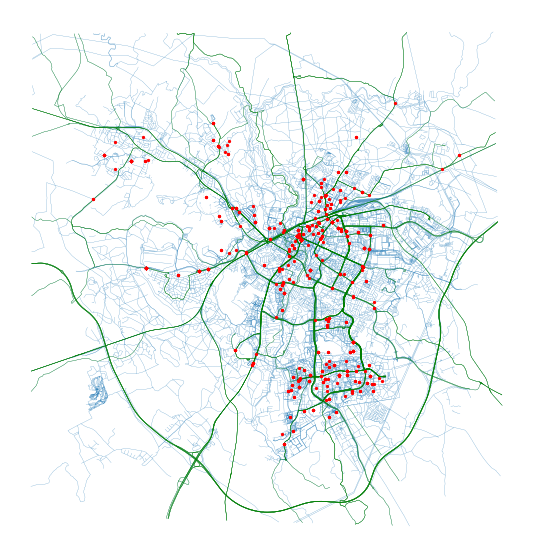

In [15]:
# plotting spacial data
fig, ax = plt.subplots(figsize=(10,10))
all_lines_cliped.plot(ax=ax, zorder=1, linewidth=0.2)
main_routes_cliped.plot(ax=ax, zorder=2, linewidth=0.3, color='green')
points.plot(ax=ax, color='red', markersize=5, zorder=3)
ax.set_axis_off()
plt.savefig('olsztyn.png', bbox_inches='tight', dpi=200)
plt.show()

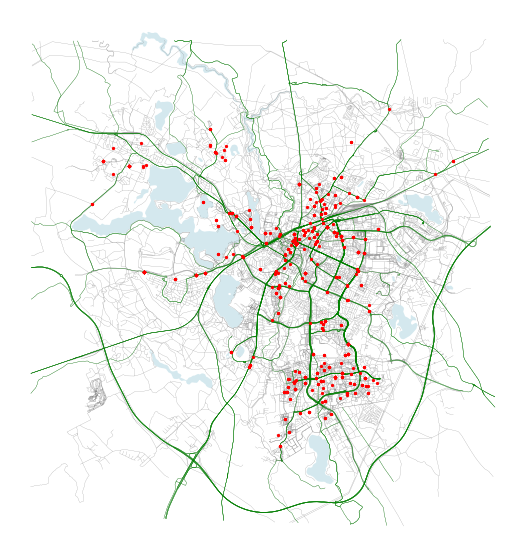

In [16]:
# plotting spacial data water_poly
fig, ax = plt.subplots(figsize=(10,10))
water_poly.plot(ax=ax, zorder=1, color='#aad3df', alpha=0.5)
all_lines_cliped.plot(ax=ax, zorder=2, linewidth=0.2, color='grey')
main_routes_cliped.plot(ax=ax, zorder=3, linewidth=0.3, color='green')
points.plot(ax=ax, color='red', markersize=5, zorder=4)
ax.set_axis_off()
plt.savefig('olsztyn_with_water_bodies.png', bbox_inches='tight', dpi=200)
plt.show()

### Price

In [17]:
import seaborn as sns
%matplotlib inline
plt.style.use("fivethirtyeight")

# current the current color palette
print(sns.color_palette().as_hex())
sns.color_palette()

['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']


[(0.0, 0.5607843137254902, 0.8352941176470589),
 (0.9882352941176471, 0.30980392156862746, 0.18823529411764706),
 (0.8980392156862745, 0.6823529411764706, 0.2196078431372549),
 (0.42745098039215684, 0.5647058823529412, 0.30980392156862746),
 (0.5450980392156862, 0.5450980392156862, 0.5450980392156862),
 (0.5058823529411764, 0.058823529411764705, 0.48627450980392156)]

In [18]:
data['rooms_umber'] = data['rooms'].str.extract('(\d+)').astype(int)
df = data[['price','price_meter','area','rooms_umber']].describe().astype(int)
df

,price,price_meter,area,rooms_umber
count,817,817,817,817
mean,555393,9716,59,2
std,314658,3275,24,0
min,200000,4421,18,1
25%,399009,7615,42,2
50%,499000,8953,55,3
75%,639000,11145,71,3
max,5000000,31053,200,6


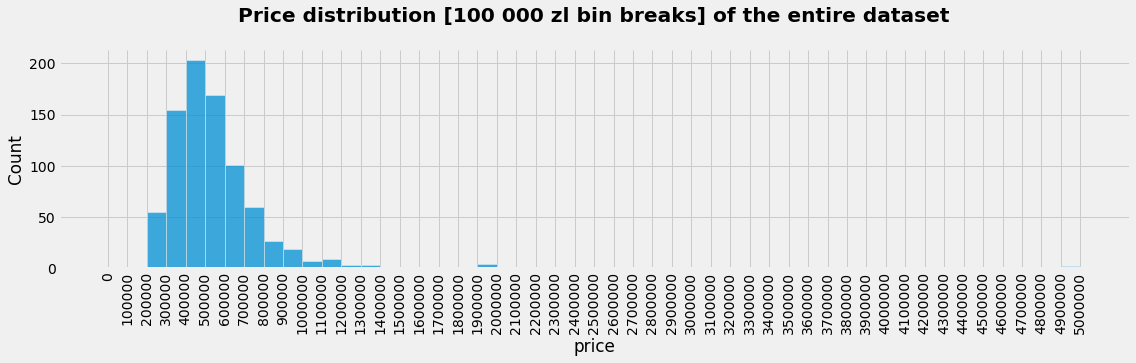

In [19]:
sns.displot(data, x="price", height=4, aspect=4, bins=list(range(0, int(max(data['price'])) + 100000, 100000)))
plt.xticks(list(range(0, int(max(data['price'])) + 100000, 100000)), rotation='vertical')
plt.title("Price distribution [100 000 zl bin breaks] of the entire dataset\n", fontweight='bold')
plt.savefig('OLSZTYNprice_distribution.png', bbox_inches='tight')
plt.show()

### Removing outliers

In [20]:
data = data[(data.price <= np.percentile(data.price, 99.5)) & (data.price > 0)]

In [21]:
df = data[['price','price_meter','area','rooms_umber']].describe().astype(int)
df

,price,price_meter,area,rooms_umber
count,812,812,812,812
mean,538667,9646,58,2
std,203639,3103,22,0
min,200000,4421,18,1
25%,399000,7586,42,2
50%,498988,8928,55,3
75%,639000,11058,71,3
max,1948660,28251,160,6


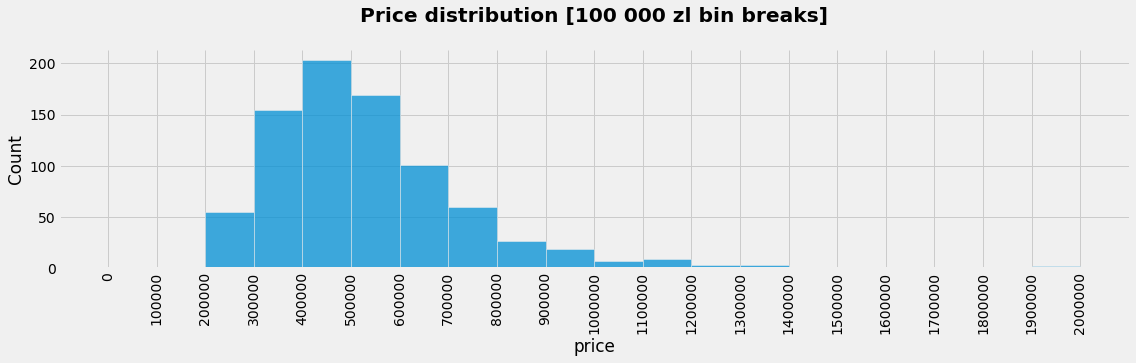

In [22]:
sns.displot(data, x="price", height=4, aspect=4, bins=list(range(0, int(max(data['price'])) + 100000, 100000)))
plt.xticks(list(range(0, int(max(data['price'])) + 100000, 100000)), rotation='vertical')
plt.title("Price distribution [100 000 zl bin breaks]\n", fontweight='bold')
plt.savefig('OLSZTYNprice_distribution.png', bbox_inches='tight')
plt.show()

**Cutting data** - left cut bins

In [23]:
r = range(0, int(max(data['price'])) + 100000, 100000)

data['LCBINS_100k'] = pd.cut(data['price'], r, right=False, labels=False)
def create_label(row):
    return str(row['LCBINS_100k'] * 100) + 'k - ' + str((row['LCBINS_100k'] + 1) * 100) +'k'

data['BINS_100k'] = data.apply(create_label, axis=1)
data.head(3)

,free_text,address,price,price_meter,rooms,area,more,add_link,Powierzchnia,Forma własności,...,Wyposażenie,Informacje dodatkowe,Materiał budynku,scraping_date,address_new,Longitude,Latitude,rooms_umber,LCBINS_100k,BINS_100k
0,"atrakcyjna kawalerka, Belweder",Mieszkanie na sprzedaż: ul. ks. Jerzego Popieł...,415000.0,10988,1 pokój,37.77,Biuro nieruchomości,/pl/oferta/atrakcyjna-kawalerka-belweder-ID4oIIB,"37,77 m²",pełna własność,...,meble,piwnica,brak informacji,2024-01-16,"ks. Jerzego Popiełuszki, Osiedle Generałów, Ol...",20.478826,53.739112,1,4,400k - 500k
1,Dwa pokoje w Centrum Miasta!,Mieszkanie na sprzedaż: al. Tadeusza Kościuszk...,359900.0,7707,2 pokoje,46.70,Biuro nieruchomości,/pl/oferta/dwa-pokoje-w-centrum-miasta-ID4onWs,"46,7 m²",pełna własność,...,brak informacji,piwnica,brak informacji,2024-01-16,"Tadeusza Kościuszki, Osiedle Kościuszki, Olszt...",20.489715,53.778847,2,3,300k - 400k
2,Dwa pokoje z potencjałem,Mieszkanie na sprzedaż: al. Aleja Wojska Polsk...,385000.0,7825,2 pokoje,49.20,Biuro nieruchomości,/pl/oferta/dwa-pokoje-z-potencjalem-ID4oFj1,"49,2 m²",Zapytaj,...,"zmywarka, lodówka, meble, piekarnik, kuchenka,...","piwnica, oddzielna kuchnia",cegła,2024-01-16,"Aleja Wojska Polskiego, Osiedle Wojska Polskie...",NaN,NaN,2,3,300k - 400k


In [24]:

df = pd.pivot_table(data, 'price','LCBINS_100k', aggfunc=['count', 'min', 'max', 'median', 'mean']).astype(int)
df.sort_index(inplace=True)
df.style.bar(subset=["count"], color='#3ca7db')

,count,min,max,median,mean
,price,price,price,price,price
LCBINS_100k,,,,,
2,55,200000,299997,270000,268961
3,154,300000,399900,369000,363017
4,203,400000,499000,449000,449515
5,169,500000,599000,549250,553484
6,101,601470,699000,655992,657328
7,60,700724,799000,749000,755716
8,27,800000,899000,830000,836596
9,19,900240,999999,960500,956292


#### AREA

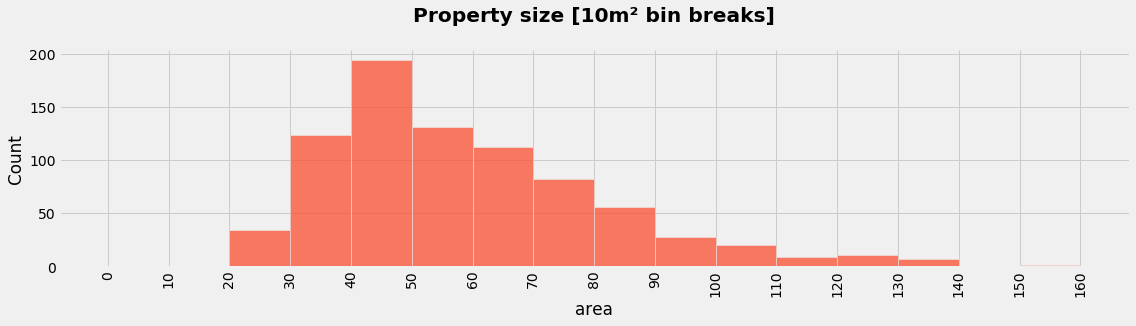

In [25]:
sns.displot(data, x="area", height=4, aspect=4, bins=list(range(0, int(max(data['area'])) + 10, 10)), color='#fc4f30' )
plt.xticks(list(range(0, int(max(data['area'])) + 10 , 10)), rotation='vertical')
plt.title("Property size [10m² bin breaks]\n", fontweight='bold')
plt.savefig('OLSZTYN_size_distribution.png', bbox_inches='tight')
plt.show()

In [26]:
r = range(0, int(max(data['area'])) + 10, 10)

data['LCBINS_10'] = pd.cut(data['area'], r, right=False, labels=False)
def create_label(row):
    return str(row['LCBINS_10'] * 10) + ' - ' + str((row['LCBINS_10'] + 1) * 10) + 'm²'

data['BINS_10'] = data.apply(create_label, axis=1)
data.head(3)

,free_text,address,price,price_meter,rooms,area,more,add_link,Powierzchnia,Forma własności,...,Materiał budynku,scraping_date,address_new,Longitude,Latitude,rooms_umber,LCBINS_100k,BINS_100k,LCBINS_10,BINS_10
0,"atrakcyjna kawalerka, Belweder",Mieszkanie na sprzedaż: ul. ks. Jerzego Popieł...,415000.0,10988,1 pokój,37.77,Biuro nieruchomości,/pl/oferta/atrakcyjna-kawalerka-belweder-ID4oIIB,"37,77 m²",pełna własność,...,brak informacji,2024-01-16,"ks. Jerzego Popiełuszki, Osiedle Generałów, Ol...",20.478826,53.739112,1,4,400k - 500k,3.0,30.0 - 40.0m²
1,Dwa pokoje w Centrum Miasta!,Mieszkanie na sprzedaż: al. Tadeusza Kościuszk...,359900.0,7707,2 pokoje,46.70,Biuro nieruchomości,/pl/oferta/dwa-pokoje-w-centrum-miasta-ID4onWs,"46,7 m²",pełna własność,...,brak informacji,2024-01-16,"Tadeusza Kościuszki, Osiedle Kościuszki, Olszt...",20.489715,53.778847,2,3,300k - 400k,4.0,40.0 - 50.0m²
2,Dwa pokoje z potencjałem,Mieszkanie na sprzedaż: al. Aleja Wojska Polsk...,385000.0,7825,2 pokoje,49.20,Biuro nieruchomości,/pl/oferta/dwa-pokoje-z-potencjalem-ID4oFj1,"49,2 m²",Zapytaj,...,cegła,2024-01-16,"Aleja Wojska Polskiego, Osiedle Wojska Polskie...",NaN,NaN,2,3,300k - 400k,4.0,40.0 - 50.0m²


In [27]:
# create dictionary
values = data[['LCBINS_10', 'BINS_10']]
values = values.drop_duplicates(subset=['LCBINS_10'], keep='first').sort_values(by=['LCBINS_10'], ascending=True) 
d = pd.Series(values['BINS_10'].values,index=values['LCBINS_10']).to_dict()

df = pd.pivot_table(data, 'area','LCBINS_10', aggfunc=['count', 'min', 'max', 'median', 'mean']).astype(int)
df.sort_index(inplace=True)

df.index = [ d[k] for k in list(df.index)]
df.style.bar(subset=["count"], color='#fc4f30')

,count,min,max,median,mean
,area,area,area,area,area
10.0 - 20.0m²,1,18,18,18,18
20.0 - 30.0m²,34,20,29,26,25
30.0 - 40.0m²,124,30,39,36,35
40.0 - 50.0m²,194,40,49,45,45
50.0 - 60.0m²,131,50,59,56,55
60.0 - 70.0m²,112,60,69,63,63
70.0 - 80.0m²,82,70,79,72,73
80.0 - 90.0m²,56,80,89,84,84
90.0 - 100.0m²,28,90,99,94,94


### Price per square metre

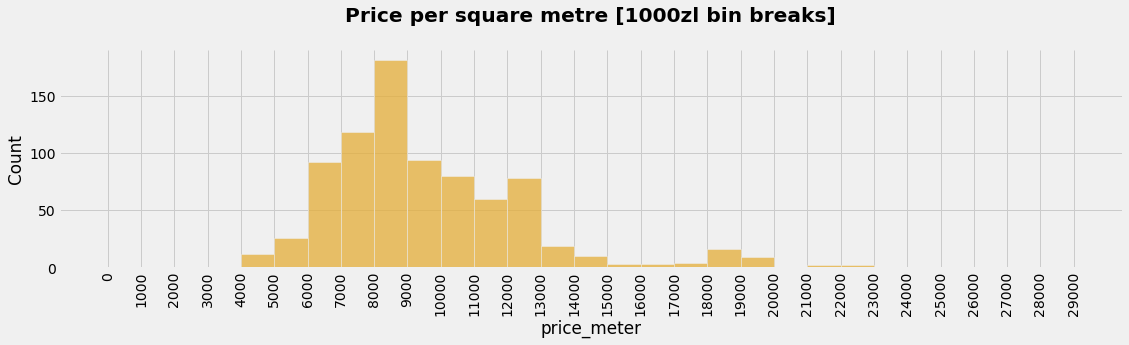

In [28]:
sns.displot(data, x="price_meter", height=4, aspect=4, bins=list(range(0, int(max(data['price_meter'])) + 1000, 1000)), color='#e5ae38' )
plt.xticks(list(range(0, int(max(data['price_meter'])) + 1000 , 1000)), rotation='vertical')
plt.title("Price per square metre [1000zl bin breaks]\n", fontweight='bold')
plt.savefig('OLSZTYN_price_meter_distribution.png', bbox_inches='tight')
plt.show()

In [29]:
r = range(0, int(max(data['price_meter'])) + 1000, 1000)

data['LCBINS_1000SQ'] = pd.cut(data['price_meter'], r, right=False, labels=False)
def create_label(row):
    return str(row['LCBINS_1000SQ'] * 1000) + ' - ' + str((row['LCBINS_1000SQ'] + 1) * 1000) + ' zl/m²'

data['BINS_10SQ'] = data.apply(create_label, axis=1)
data.head(3)

,free_text,address,price,price_meter,rooms,area,more,add_link,Powierzchnia,Forma własności,...,address_new,Longitude,Latitude,rooms_umber,LCBINS_100k,BINS_100k,LCBINS_10,BINS_10,LCBINS_1000SQ,BINS_10SQ
0,"atrakcyjna kawalerka, Belweder",Mieszkanie na sprzedaż: ul. ks. Jerzego Popieł...,415000.0,10988,1 pokój,37.77,Biuro nieruchomości,/pl/oferta/atrakcyjna-kawalerka-belweder-ID4oIIB,"37,77 m²",pełna własność,...,"ks. Jerzego Popiełuszki, Osiedle Generałów, Ol...",20.478826,53.739112,1,4,400k - 500k,3.0,30.0 - 40.0m²,10,10000 - 11000 zl/m²
1,Dwa pokoje w Centrum Miasta!,Mieszkanie na sprzedaż: al. Tadeusza Kościuszk...,359900.0,7707,2 pokoje,46.70,Biuro nieruchomości,/pl/oferta/dwa-pokoje-w-centrum-miasta-ID4onWs,"46,7 m²",pełna własność,...,"Tadeusza Kościuszki, Osiedle Kościuszki, Olszt...",20.489715,53.778847,2,3,300k - 400k,4.0,40.0 - 50.0m²,7,7000 - 8000 zl/m²
2,Dwa pokoje z potencjałem,Mieszkanie na sprzedaż: al. Aleja Wojska Polsk...,385000.0,7825,2 pokoje,49.20,Biuro nieruchomości,/pl/oferta/dwa-pokoje-z-potencjalem-ID4oFj1,"49,2 m²",Zapytaj,...,"Aleja Wojska Polskiego, Osiedle Wojska Polskie...",NaN,NaN,2,3,300k - 400k,4.0,40.0 - 50.0m²,7,7000 - 8000 zl/m²


In [30]:
# create dictionary
values = data[['LCBINS_1000SQ', 'BINS_10SQ']]
values = values.drop_duplicates(subset=['LCBINS_1000SQ'], keep='first').sort_values(by=['LCBINS_1000SQ'], ascending=True) 
d = pd.Series(values['BINS_10SQ'].values,index=values['LCBINS_1000SQ']).to_dict()

df = pd.pivot_table(data, 'price_meter','LCBINS_1000SQ', aggfunc=['count', 'min', 'max', 'median', 'mean']).astype(int)
df.sort_index(inplace=True)

df.index = [ d[k] for k in list(df.index)]
df.style.bar(subset=["count"], color='#e5ae38')

,count,min,max,median,mean
,price_meter,price_meter,price_meter,price_meter,price_meter
4000 - 5000 zl/m²,12,4421,4960,4685,4684
5000 - 6000 zl/m²,26,5020,5989,5591,5583
6000 - 7000 zl/m²,92,6000,6992,6599,6574
7000 - 8000 zl/m²,118,7000,7992,7484,7499
8000 - 9000 zl/m²,181,8000,8999,8548,8553
9000 - 10000 zl/m²,94,9000,9999,9486,9489
10000 - 11000 zl/m²,80,10000,10999,10500,10537
11000 - 12000 zl/m²,60,11000,11999,11453,11464
12000 - 13000 zl/m²,78,12000,12999,12400,12482


### ROOMS number

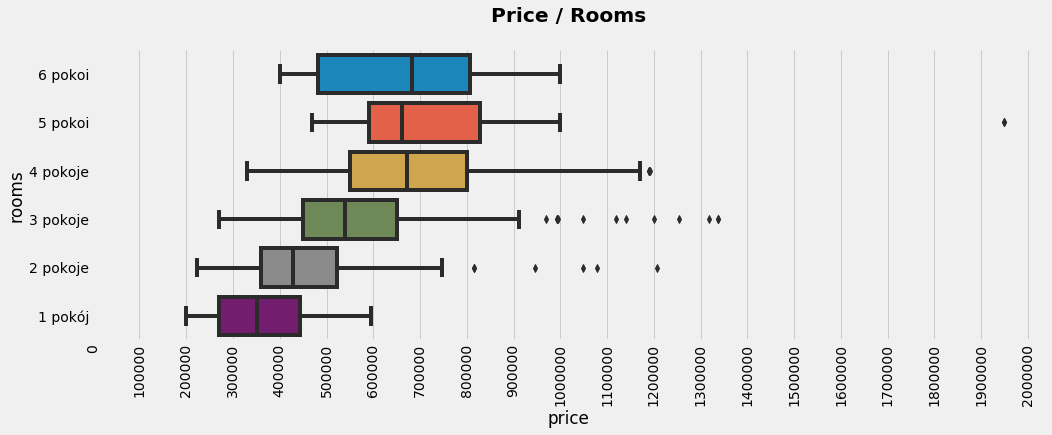

In [31]:
data = data.sort_values(by=['rooms'], ascending=False)  
sns.catplot(data=data, x="price", y="rooms", kind="box", height=5, aspect=3)
plt.xticks(list(range(0, int(max(data['price'])) + 100000, 100000)), rotation='vertical')
plt.title('Price / Rooms\n', fontweight='bold')
plt.savefig('OLSZTYN_rooms_price.png', bbox_inches='tight')
plt.show()

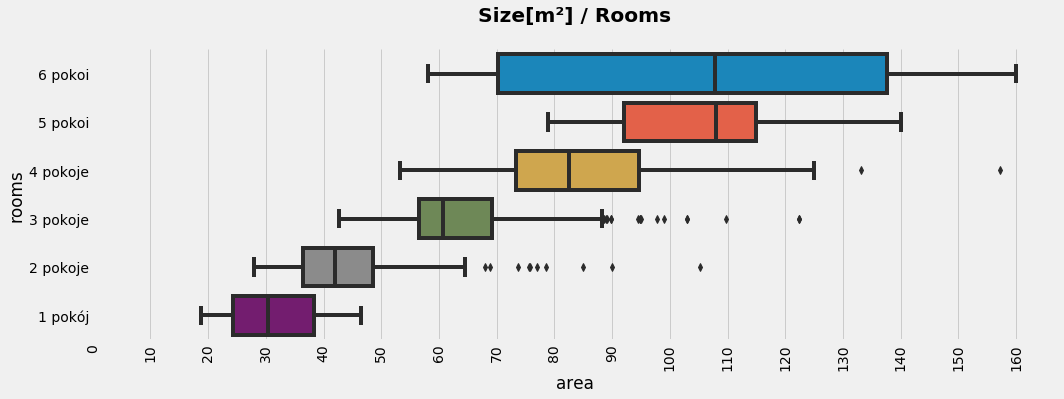

In [32]:
data = data.sort_values(by=['rooms'], ascending=False)  
sns.catplot(data=data, x="area", y="rooms", kind="box", height=5, aspect=3)
plt.xticks(list(range(0, int(max(data['area'])) + 10 , 10)), rotation='vertical')
plt.title('Size[m²] / Rooms\n', fontweight='bold')
plt.savefig('OLSZTYN_rooms_size.png', bbox_inches='tight')
plt.show()

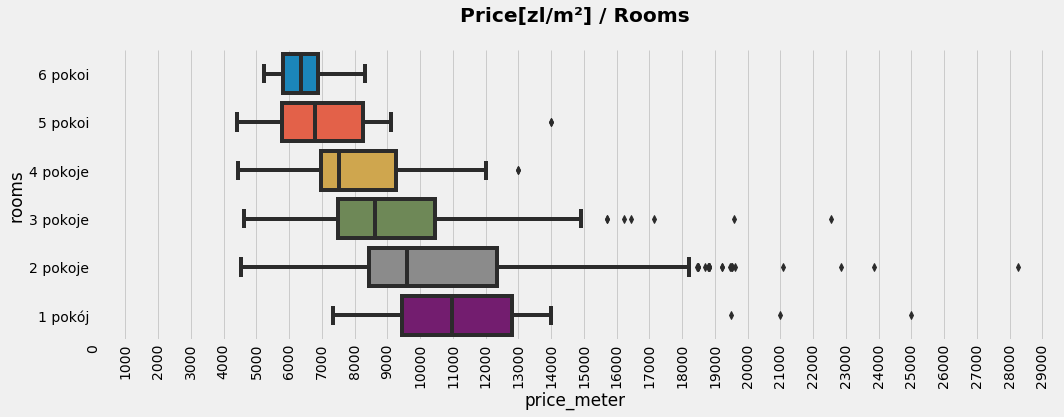

In [33]:
data = data.sort_values(by=['rooms'], ascending=False)  
sns.catplot(data=data, x="price_meter", y="rooms", kind="box", height=5, aspect=3)
plt.xticks(list(range(0, int(max(data['price_meter'])) + 1000 , 1000)), rotation='vertical')
plt.title('Price[zl/m²] / Rooms\n', fontweight='bold')
plt.savefig('OLSZTYN_rooms_price_meter.png', bbox_inches='tight')
plt.show()

In [34]:
data.columns

Index(['free_text', 'address', 'price', 'price_meter', 'rooms', 'area', 'more',
       'add_link', 'Powierzchnia', 'Forma własności', 'Liczba pokoi',
       'Stan wykończenia', 'Piętro', 'Balkon / ogród / taras', 'Czynsz',
       'Miejsce parkingowe', 'Obsługa zdalna', 'Ogrzewanie', 'Rynek',
       'Typ ogłoszeniodawcy', 'Dostępne od', 'Rok budowy', 'Rodzaj zabudowy',
       'Okna', 'Winda', 'Media', 'Zabezpieczenia', 'Wyposażenie',
       'Informacje dodatkowe', 'Materiał budynku', 'scraping_date',
       'address_new', 'Longitude', 'Latitude', 'rooms_umber', 'LCBINS_100k',
       'BINS_100k', 'LCBINS_10', 'BINS_10', 'LCBINS_1000SQ', 'BINS_10SQ'],
      dtype='object')

### Additiona information

In [35]:
# we need to set 'miejskie' as None values 

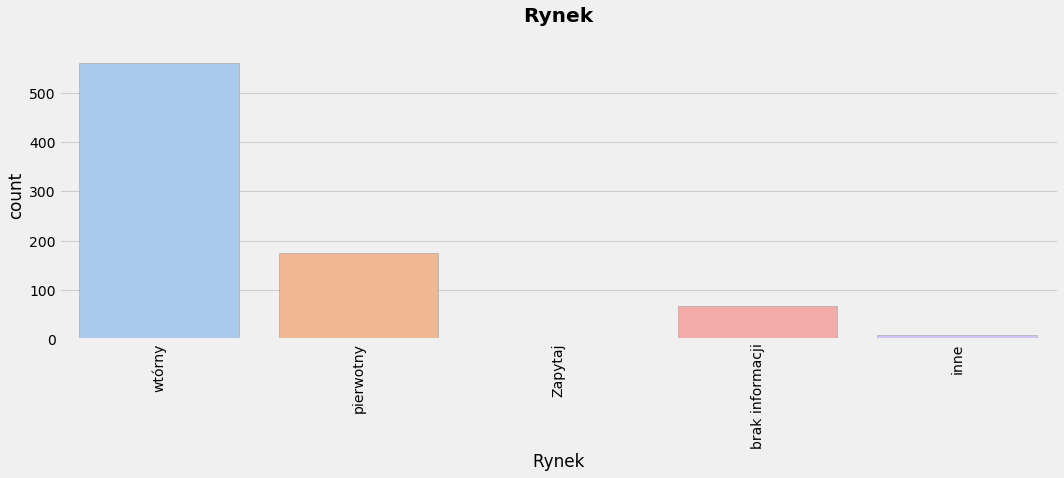

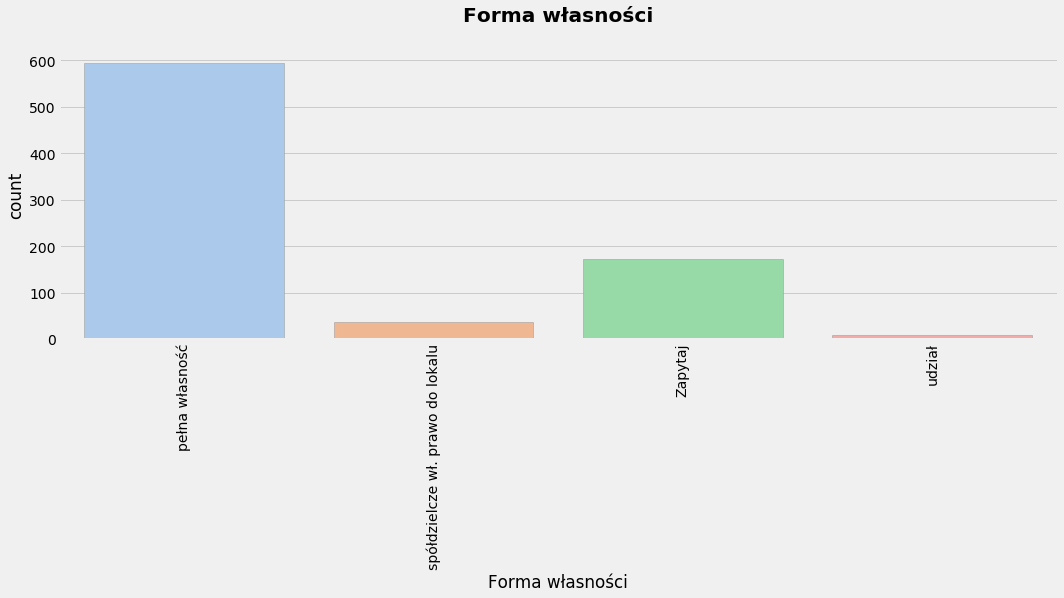

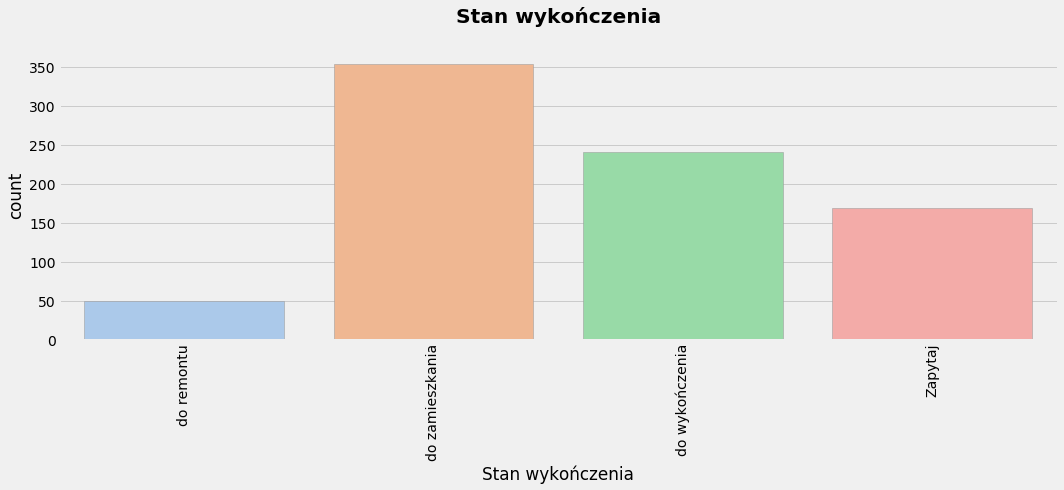

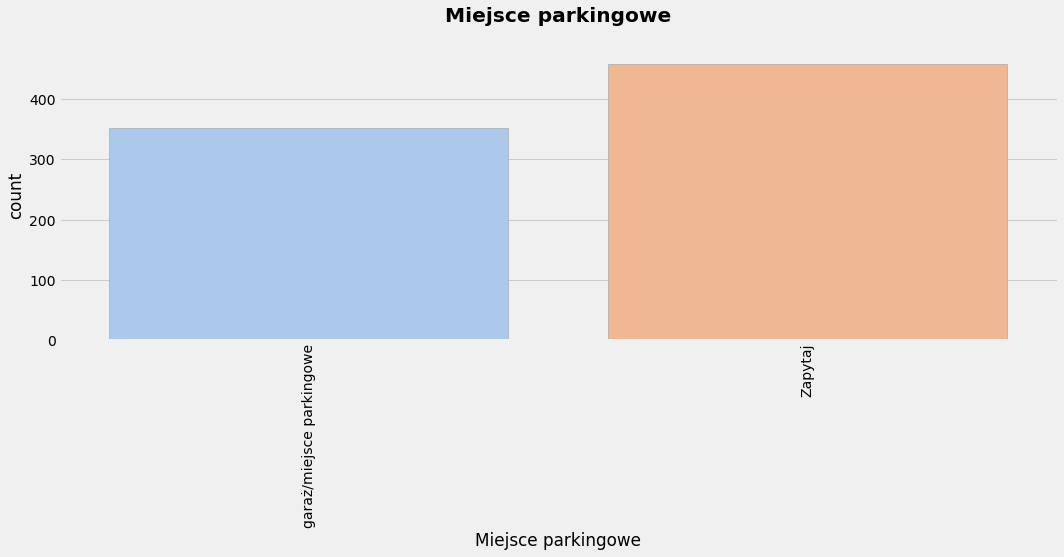

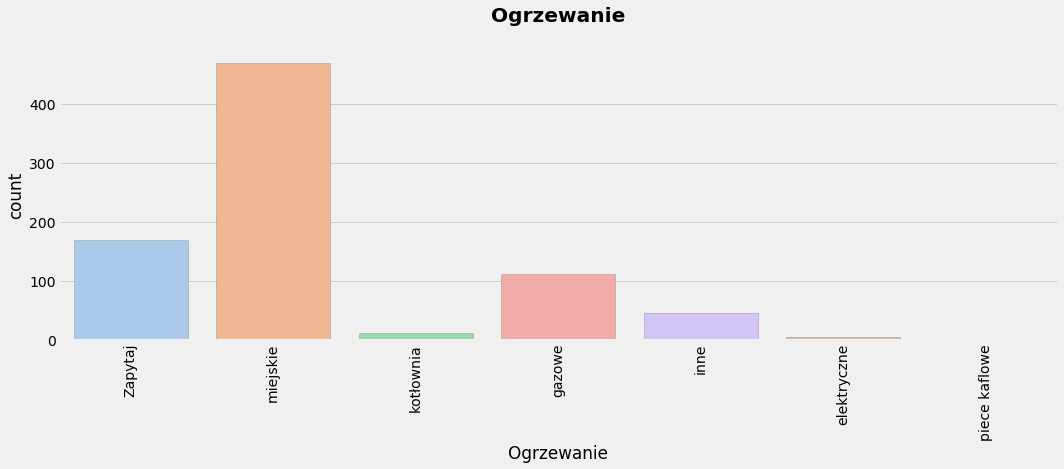

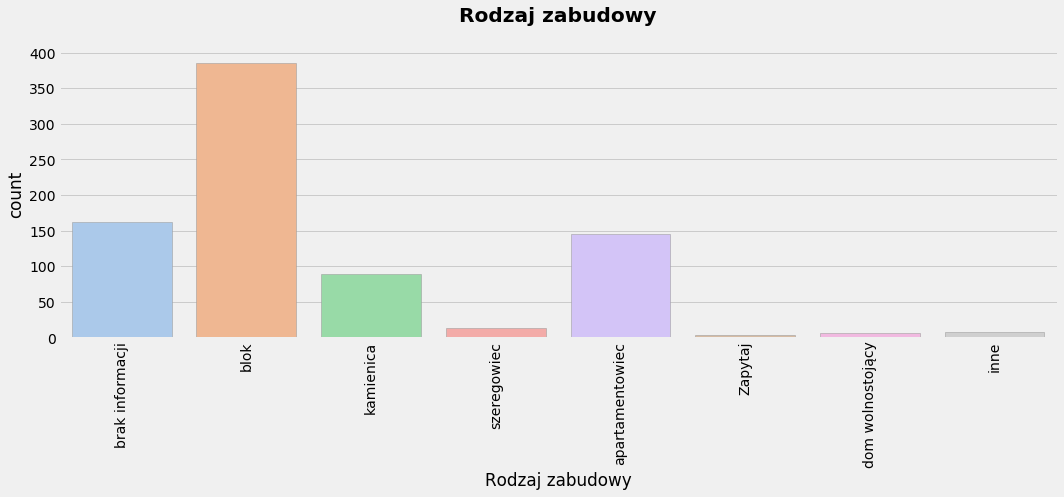

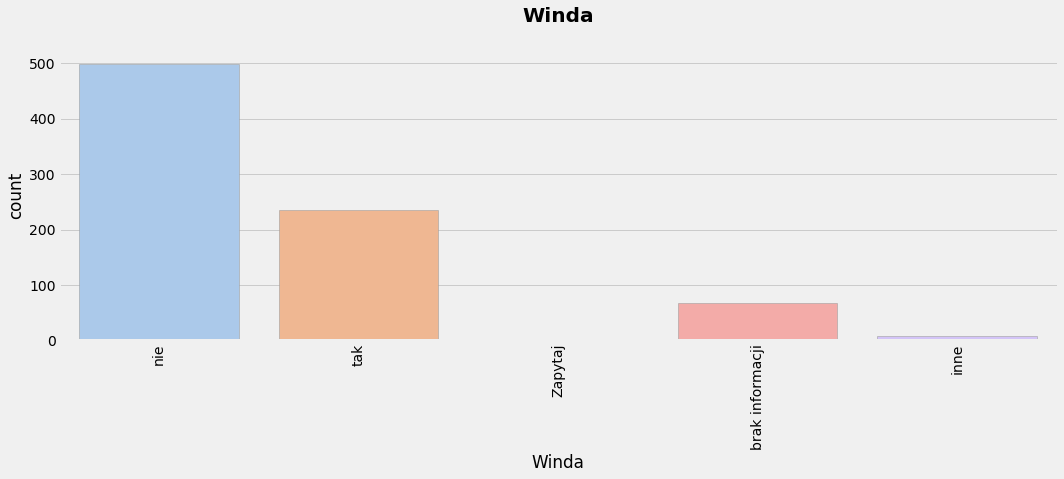

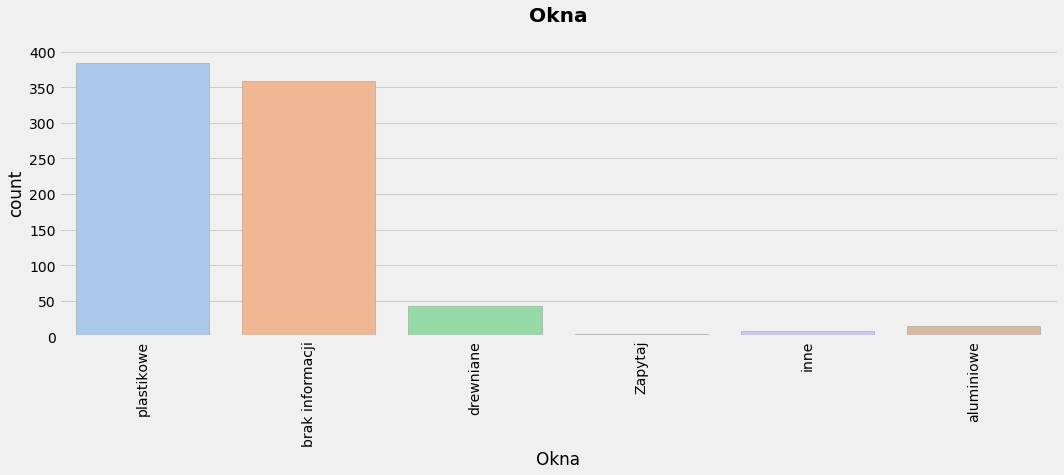

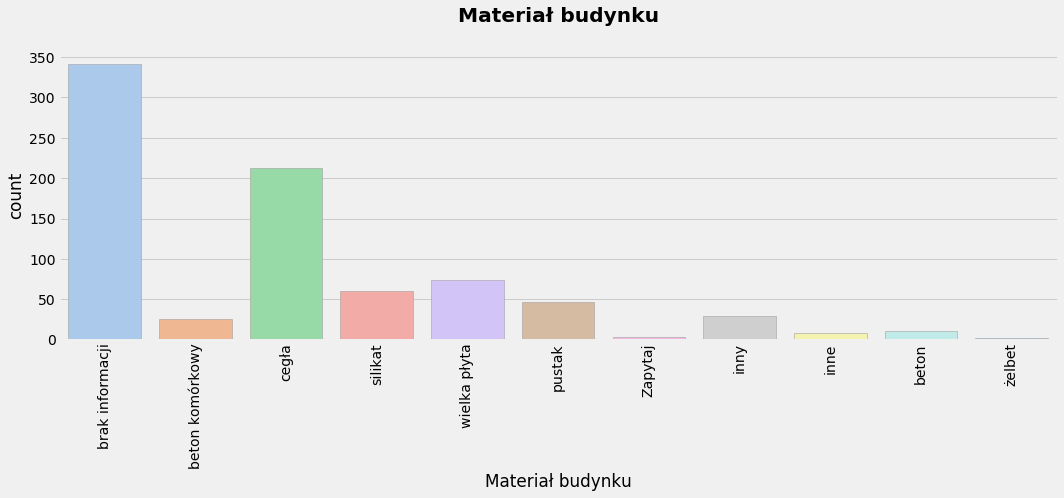

In [36]:
for i,v in enumerate( ['Rynek', 'Forma własności', 'Stan wykończenia', 'Miejsce parkingowe', 'Ogrzewanie', 'Rodzaj zabudowy'
                      ,'Winda', 'Okna', 'Materiał budynku']):
    sns.catplot(
        data=data, x=v, kind="count",
        palette="pastel", edgecolor=".6", height=5, aspect=3
    )
    plt.xticks(rotation='vertical')
    plt.title(f'{v}\n', fontweight='bold')
    plt.savefig(f'olsztyn_details_{i}.png', bbox_inches='tight')
    plt.show()

In [37]:
data['Rok budowy'].unique()

array(['1940', '2003', '2023', '1910', '2007', '2005', '2024', '1920',
       'brak informacji', '1990', '1960', '1905', '1998', '1950', '2001',
       '2022', '1996', '2008', '2013', '1948', '1970', '1932', '2010',
       '1983', '1995', '3022', '2000', '1997', '2009', '1991', '1986',
       '1984', '1992', '1978', 'Zapytaj', '1906', '2020', '1913', '1989',
       '1982', '1897', '2002', '1999', '2004', '1922', '1890', '1907',
       '2017', '2019', '1965', '2021', '2018', '1966', '1902', '1880',
       '2025', '1973', '1958', '1988', '1936', 'inne', '1976', '1979',
       '1971', '2012', '1900', '1969', '1975', '1930', '2011', '1942',
       '1957', '1980', '1981', '2014', '1974', '1918', '1967', '1985',
       '1929', '1908', '1994', '1928', '1954', '1912', '2015', '1968',
       '1955', '2006', '1933', '1993', '2016', '1962', '1977', '1961',
       '1956', '1925', '1949', '1', '1964'], dtype=object)

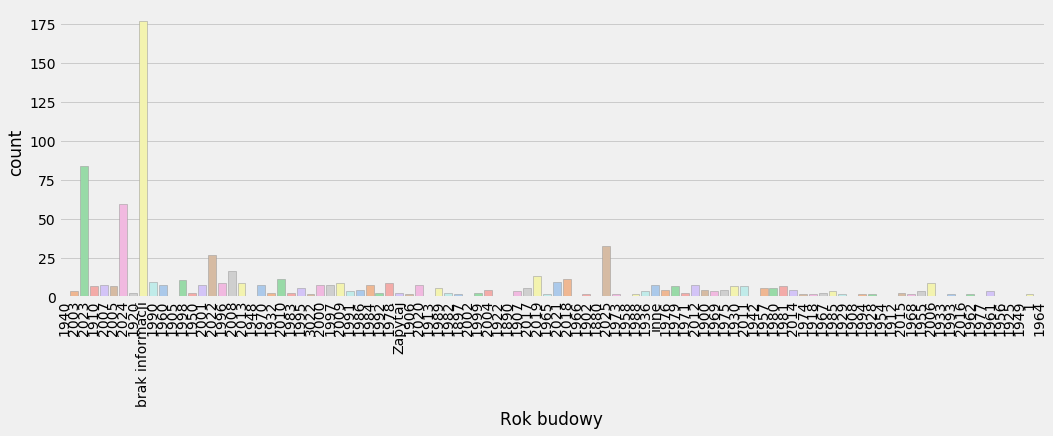

In [38]:
sns.catplot(
        data=data, x='Rok budowy', kind="count",
        palette="pastel", edgecolor=".6", height=5, aspect=3
    )
plt.xticks(rotation='vertical')
data['Rok budowy'].unique()
plt.show()

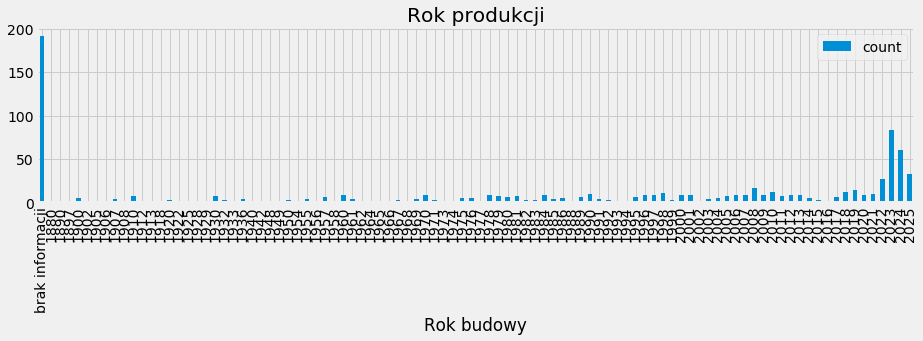

,count
Rok budowy,
brak informacji,192
1880,1


In [39]:
# without bins
df = data.copy()
def clean_rok(row):
    if row['Rok budowy'] in ['1', 'Zapytaj', 'inne', '3022']:
        return 'brak informacji'  
    return row['Rok budowy']

df['Rok budowy'] = df.apply(clean_rok, axis=1)

df = df.groupby(by=['Rok budowy']).count()[['address']]
df.columns = ['count']
df['year_int'] = [int('0'.strip()) if x=='brak informacji'  else int(x.strip()) for x in list(df.index)]
df.sort_values(by=['year_int'], ascending=True, inplace=True) 
df = df[['count']]
df.plot.bar(figsize=(14,3))
plt.title("Rok produkcji")
plt.show()
df.head(2)

In [40]:
# with bins
# without bins
df = data.copy()
def clean_rok(row):
    if row['Rok budowy'] in ['1', 'Zapytaj', 'inne', '3022']:
        return 'brak informacji'  
    return row['Rok budowy']

df['Rok budowy'] = df.apply(clean_rok, axis=1)

df = df.groupby(by=['Rok budowy']).count()[['address']]
df.columns = ['count']
df['year_int'] = [int('0'.strip()) if x=='brak informacji'  else int(x.strip()) for x in list(df.index)]
df.sort_values(by=['year_int'], ascending=True, inplace=True) 

df

,count,year_int
Rok budowy,,
brak informacji,192,0
1880,1,1880
1890,1,1890
1897,2,1897
1900,5,1900
...,...,...
2021,10,2021
2022,27,2022
2023,84,2023


In [41]:
df['year_int'][1]

1880

In [42]:
df['Rok budowy'] = df.index
bins=list(range(df['year_int'][1], int(max(df['year_int'])) + 10, 10))

In [43]:
a = ("John", "Charles", "Mike")
b = ("Jenny", "Christy", "Monica")
dict(zip(a, b))

{'John': 'Jenny', 'Charles': 'Christy', 'Mike': 'Monica'}

,Rok budowy,year_int,year_int_bin
37,brak informacji,0,9999
798,brak informacji,0,9999


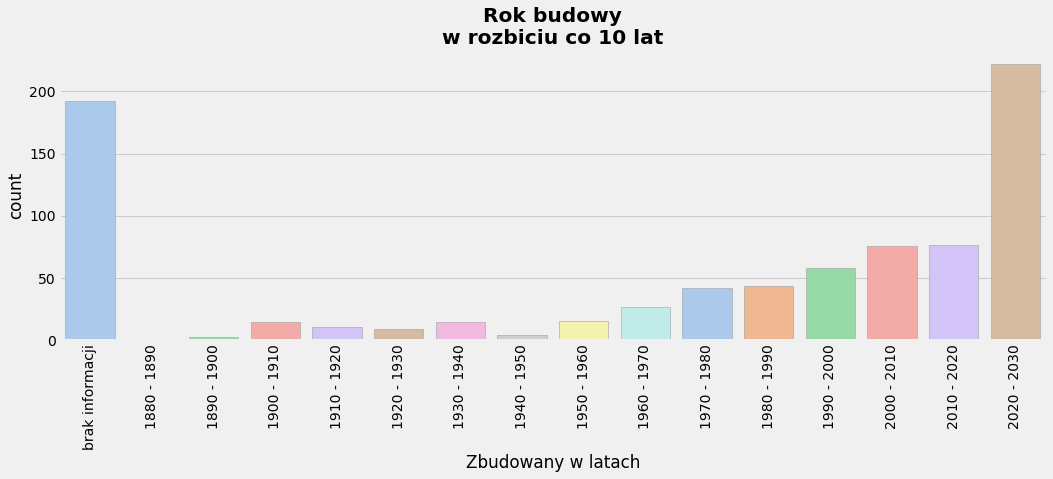

In [44]:
# witH bins 10 years
df = data.copy()
def clean_rok(row):
    if row['Rok budowy'] in ['1', 'Zapytaj', 'inne', '3022']:
        return 'brak informacji'  
    return row['Rok budowy']

df['Rok budowy'] = df.apply(clean_rok, axis=1)

df['Rok budowy'].unique()
df['year_int'] = [int('0'.strip()) if x=='brak informacji'  else int(x.strip()) for x in list(df['Rok budowy'])]
df['Rok budowy'].unique()

df = df[['Rok budowy', 'year_int']]

no_data = df.loc[df['year_int'] == 0]
df = df.loc[df['year_int'] != 0]

no_data['year_int_bin'] = 9999

bins=list(range(min(df['year_int']), int(max(df['year_int'])) + 10, 10))
df['year_int_bin'] = pd.cut(df['year_int'], bins, right=False, labels=False)
df.sort_values(by=['year_int_bin'], ascending=True, inplace=True)
bins_string = ['brak informacji'] + [ f'{i} - {i + 10}' for i in bins]
bins_keys = [9999] + list(df['year_int_bin'].unique())
mapping = dict(zip(bins_keys, bins_string))

def map_data(row):
    return mapping[row['year_int_bin']]

df = no_data.append(df)
display(df.head(2))

df['Zbudowany w latach'] = df.apply(map_data,axis=1)
sns.catplot(
        data=df, x='Zbudowany w latach', kind="count",
        palette="pastel", edgecolor=".6", height=5, aspect=3
    )
plt.xticks(rotation='vertical')
plt.title(f'Rok budowy\nw rozbiciu co 10 lat', fontweight='bold')
plt.savefig(f'olsztyn_details_10_rok_budow.png', bbox_inches='tight')
plt.show()


,Rok budowy,year_int,year_int_bin
37,brak informacji,0,9999
798,brak informacji,0,9999


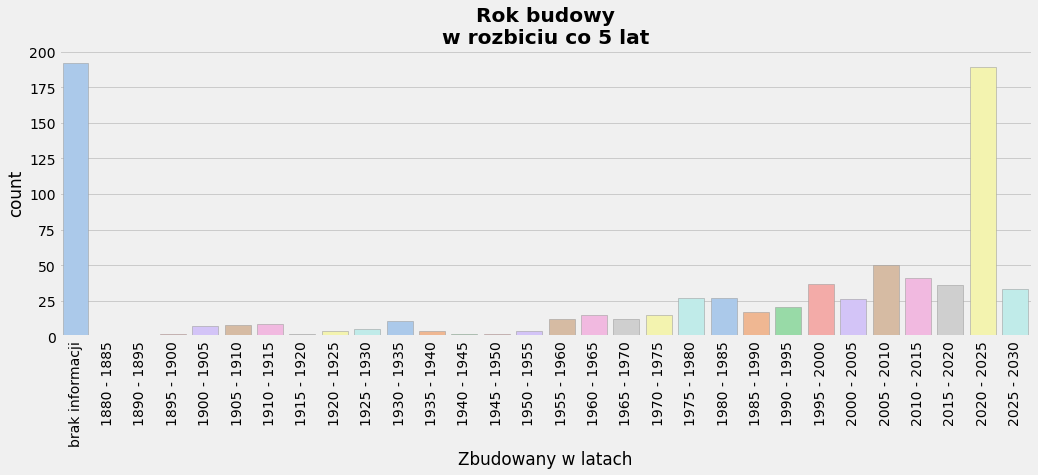

In [45]:
# witH bins 5 years
df = data.copy()
def clean_rok(row):
    if row['Rok budowy'] in ['1', 'Zapytaj', 'inne', '3022']:
        return 'brak informacji'  
    return row['Rok budowy']

df['Rok budowy'] = df.apply(clean_rok, axis=1)

df['Rok budowy'].unique()
df['year_int'] = [int('0'.strip()) if x=='brak informacji'  else int(x.strip()) for x in list(df['Rok budowy'])]
df['Rok budowy'].unique()

df = df[['Rok budowy', 'year_int']]

no_data = df.loc[df['year_int'] == 0]
df = df.loc[df['year_int'] != 0]

no_data['year_int_bin'] = 9999

bins=list(range(min(df['year_int']), int(max(df['year_int'])) + 10, 5))
df['year_int_bin'] = pd.cut(df['year_int'], bins, right=False, labels=False)
df.sort_values(by=['year_int_bin'], ascending=True, inplace=True)

bins_string = ['brak informacji'] + [ f'{i} - {i + 5}' for i in bins]
bins_keys = [9999] + list(range(df['year_int_bin'].unique()[-1] + 1))
mapping = dict(zip(bins_keys, bins_string))

def map_data(row):
    return mapping[row['year_int_bin']]

df = no_data.append(df)
display(df.head(2))

df['Zbudowany w latach'] = df.apply(map_data,axis=1)
sns.catplot(
        data=df, x='Zbudowany w latach', kind="count",
        palette="pastel", edgecolor=".6", height=5, aspect=3
    )
plt.xticks(rotation='vertical')
plt.title(f'Rok budowy\nw rozbiciu co 5 lat', fontweight='bold')
plt.savefig(f'olsztyn_details_5_rok_budow.png', bbox_inches='tight')
plt.show()

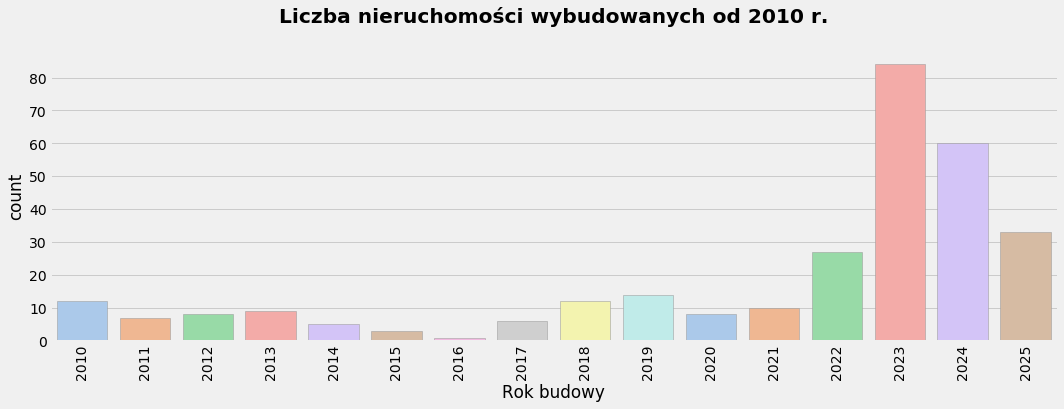

In [53]:
# witH bins 5 years
df = data.copy()
def clean_rok(row):
    if row['Rok budowy'] in ['1', 'Zapytaj', 'inne', '3022']:
        return 'brak informacji'  
    return row['Rok budowy']

df['Rok budowy'] = df.apply(clean_rok, axis=1)

df['Rok budowy'].unique()
df['year_int'] = [int('0'.strip()) if x=='brak informacji'  else int(x.strip()) for x in list(df['Rok budowy'])]
df = df[['Rok budowy', 'year_int']]

no_data = df.loc[df['year_int'] == 0]
df = df.loc[df['year_int'] >= 2010]
df.sort_values(by=['year_int'], ascending=True, inplace=True)

sns.catplot(
        data=df, x='Rok budowy', kind="count",
        palette="pastel", edgecolor=".6", height=5, aspect=3
    )
plt.xticks(rotation='vertical')
plt.title(f'Liczba nieruchomości wybudowanych od 2010 r.\n', fontweight='bold')
plt.savefig(f'olsztyn_details_2010_rok_budow.png', bbox_inches='tight')
plt.show()